In [ ]:
# 使用的是Kaggele上的数据，能够直接导入
# 直接运行这段代码就可以了

!pip install kaggle
import json
token = {"username":"awc789","key":"454f1e97dae3d3abc28488f3d31cf09e"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle competitions download -c nyc-taxi-trip-duration

- path is now set to: /content
  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 83.6MB/s]
 79% 50.0M/62.9M [00:00<00:00, 104MB/s]
100% 62.9M/62.9M [00:00<00:00, 117MB/s]
 88% 18.0M/20.3M [00:00<00:00, 81.8MB/s]
100% 20.3M/20.3M [00:00<00:00, 79.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/competitions/nyc-taxi-trip-duration/test.zip
!unzip /content/competitions/nyc-taxi-trip-duration/train.zip

Archive:  /content/competitions/nyc-taxi-trip-duration/test.zip
  inflating: test.csv                
Archive:  /content/competitions/nyc-taxi-trip-duration/train.zip
  inflating: train.csv               


In [ ]:
# 读取数据
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy.stats import boxcox
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

train = train.drop(['id','vendor_id','store_and_fwd_flag'],axis=1)
test = test.drop(['id','vendor_id','store_and_fwd_flag'],axis=1)

train.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


In [ ]:
test.head()

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680
1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403
2,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523
3,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469
4,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890


In [ ]:
# 特征工程
from datetime import datetime
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_datetime    1458644 non-null  object 
 1   dropoff_datetime   1458644 non-null  object 
 2   passenger_count    1458644 non-null  int64  
 3   pickup_longitude   1458644 non-null  float64
 4   pickup_latitude    1458644 non-null  float64
 5   dropoff_longitude  1458644 non-null  float64
 6   dropoff_latitude   1458644 non-null  float64
 7   trip_duration      1458644 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 89.0+ MB


In [ ]:
# 生成欧式距离特征
train['x'] = (train.pickup_longitude - train.dropoff_longitude)**2
train['y'] = (train.pickup_latitude - train.dropoff_latitude)**2
train['distance_sqrt'] = train.x + train.y
train['distance'] = np.sqrt(train.distance_sqrt) * 1000

test['x'] = (test.pickup_longitude - test.dropoff_longitude)**2
test['y'] = (test.pickup_latitude - test.dropoff_latitude)**2
test['distance_sqrt'] = test.x + test.y
test['distance'] = np.sqrt(test.distance_sqrt) *1000

train = train.drop(['x','y','distance_sqrt'],axis=1)
test = test.drop(['x','y','distance_sqrt'],axis=1)

# 生成曼哈顿距离特征
train['manhattan_distance'] = (abs(train.dropoff_longitude - train.pickup_longitude) +
                            abs(train.dropoff_latitude - train.pickup_latitude))
test['manhattan_distance'] = (abs(test.dropoff_longitude - test.pickup_longitude) +
                            abs(test.dropoff_latitude - test.pickup_latitude))

# 生成Haversine Distance特征
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r
                                          
train['haversine_distance'] = train.apply(lambda r: haversine(r['pickup_latitude'],r['pickup_longitude'],
                                                                  r['dropoff_latitude'], r['dropoff_longitude']), axis=1)
test['haversine_distance'] = test.apply(lambda r: haversine(r['pickup_latitude'],r['pickup_longitude'],
                                                                  r['dropoff_latitude'], r['dropoff_longitude']), axis=1)

print(len(train))

1458644


In [ ]:
from geopy.distance import geodesic

def get_distance(source_lat, source_long, dest_lat, dest_long):
    # Returns the distance in Miles between the source and the destination.
    
    distance = geodesic((source_lat, source_long), 
                        (dest_lat, dest_long)).miles
    return distance

train['miles_distance'] = train.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,
                                                       x.dropoff_latitude, x.dropoff_longitude), axis=1)

train.head()

# sns.set(rc={'figure.figsize':(15, 5)})
# sns.distplot(train['trip_duration'].values/3600, axlabel = 'Trip Duration (in Hours)', bins = 75)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,manhattan_distance,haversine_distance,miles_distance
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,17.679539,0.019859,1.498521,0.933406
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,20.455904,0.026478,1.805507,1.123849
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,59.933799,0.080158,6.385098,3.964154
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,13.438206,0.015480,1.485498,0.921886
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,10.689569,0.010818,1.188588,0.737591


In [ ]:
# 通过经纬度计算出航向角
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

train['bearing'] = calculate_bearing(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)
test['bearing'] = calculate_bearing(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


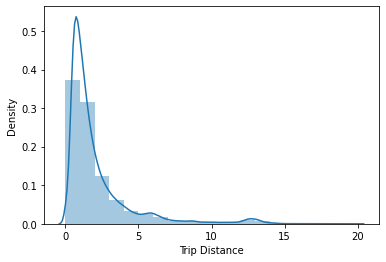

In [ ]:
df_filtered = train[train['miles_distance'] <= 20].copy()
sns.distplot(df_filtered['miles_distance'].values, axlabel = 'Trip Distance', bins = 20)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


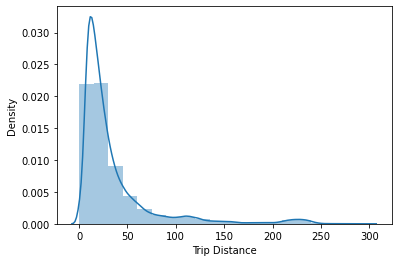

In [ ]:
df_filtered = train[train['distance'] <= 300].copy()
sns.distplot(df_filtered['distance'].values, axlabel = 'Trip Distance', bins = 20)

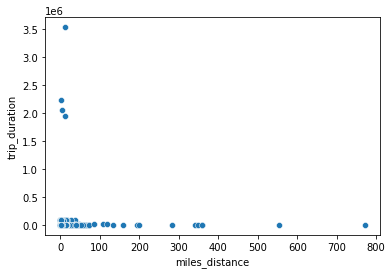

In [ ]:
sns.scatterplot(data=train, x="miles_distance", y="trip_duration")

In [ ]:
# 生成月份 / 日期 / 星期 /时上车时间 特征
data = train.copy()
year = data['pickup_datetime'].apply(lambda x:x[0:4])
month = data['pickup_datetime'].apply(lambda x:x[5:7])
day = data['pickup_datetime'].apply(lambda x:x[8:10])

pickup_hour = data['pickup_datetime'].apply(lambda x:x[11:13])
pickup_minute = data['pickup_datetime'].apply(lambda x:x[14:16])
pickup_second = data['pickup_datetime'].apply(lambda x:x[17:])

weekday = []
pickup_time =[]
for i in range(len(year)):
  date = str(year[i])+str(month[i])+str(day[i])
  w = datetime.strptime(date, "%Y%m%d").weekday()
  weekday.append(w)

  p_time = int(pickup_hour[i]) + int(pickup_minute[i])/60 + int(pickup_second[i])/360
  pickup_time.append(p_time)

data['month'] = month
data['day'] = day
data['weekday'] = weekday
data['pickup_time'] = pickup_time

train = data.drop(['dropoff_datetime','pickup_datetime'],axis=1)
# train.info()

In [ ]:
data = test.copy()
year = data['pickup_datetime'].apply(lambda x:x[0:4])
month = data['pickup_datetime'].apply(lambda x:x[5:7])
day = data['pickup_datetime'].apply(lambda x:x[8:10])

pickup_hour = data['pickup_datetime'].apply(lambda x:x[11:13])
pickup_minute = data['pickup_datetime'].apply(lambda x:x[14:16])
pickup_second = data['pickup_datetime'].apply(lambda x:x[17:])

weekday = []
pickup_time =[]
for i in range(len(year)):
  date = str(year[i])+str(month[i])+str(day[i])
  w = datetime.strptime(date, "%Y%m%d").weekday()
  weekday.append(w)

  p_time = int(pickup_hour[i]) + int(pickup_minute[i])/60 + int(pickup_second[i])/360
  pickup_time.append(p_time)

data['month'] = month
data['day'] = day
data['weekday'] = weekday
data['pickup_time'] = pickup_time

test = data.drop(['pickup_datetime'],axis=1)
# test.info()

In [ ]:
# 使用PCA将经纬度数据完成2D->2D的转化

from sklearn.decomposition import PCA
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1458644 non-null  int64  
 1   pickup_longitude    1458644 non-null  float64
 2   pickup_latitude     1458644 non-null  float64
 3   dropoff_longitude   1458644 non-null  float64
 4   dropoff_latitude    1458644 non-null  float64
 5   trip_duration       1458644 non-null  int64  
 6   distance            1458644 non-null  float64
 7   manhattan_distance  1458644 non-null  float64
 8   haversine_distance  1458644 non-null  float64
 9   miles_distance      1458644 non-null  float64
 10  bearing             1458644 non-null  float64
 11  month               1458644 non-null  object 
 12  day                 1458644 non-null  object 
 13  weekday             1458644 non-null  int64  
 14  pickup_time         1458644 non-null  float64
 15  pickup_pca0    

In [ ]:
# 生成区域特征 （Brookly / Staten_island / Manhattan / Bronx / Queens）

y = train.trip_duration
X_train = train.drop(['trip_duration'],axis=1)

# 上车区域
train_pickup_borough = []
for j,k in zip(X_train.pickup_longitude,X_train.pickup_latitude):
    if ((j>=-74.040269) and (j<=-73.865036)) and ((k>=40.574031) and (k<=40.736728)):
        train_pickup_borough.append('Brooklyn')
    elif ((j>=-74.245856) and (j<=-73.057562)) and ((k>=40.502863) and (k<=40.647234)):
        train_pickup_borough.append('Staten_island')
    elif ((j>=-74.011645) and (j<=-73.913772)) and ((k>=40.703384) and (k<=40.876058)):
        train_pickup_borough.append('Manhattan')
    elif ((j>=-73.931573) and (j<=-73.781473)) and ((k>=40.797766) and (k<=40.912460)):
        train_pickup_borough.append('Bronx')
    else: train_pickup_borough.append('Queens')
Borough_ptrain = pd.DataFrame(train_pickup_borough,columns=['pickup_borough'])
X_train = pd.concat([X_train,Borough_ptrain], axis=1)

# 下车区域
train_dropoff_borough = []
for d,f in zip(X_train.dropoff_longitude,X_train.dropoff_latitude):
    if ((d>=-74.040269) and (d<=-73.865036)) and ((f>=40.574031) and (f<=40.736728)):
        train_dropoff_borough.append('Brooklyn')
    elif ((d>=-74.245856) and (d<=-73.057562)) and ((f>=40.502863) and (f<=40.647234)):
        train_dropoff_borough.append('Staten_island')
    elif ((d>=-74.011645) and (d<=-73.913772)) and ((f>=40.703384) and (f<=40.876058)):
        train_dropoff_borough.append('Manhattan')
    elif ((d>=-73.931573) and (d<=-73.781473)) and ((f>=40.797766) and (f<=40.912460)):
        train_dropoff_borough.append('Bronx')
    else: train_dropoff_borough.append('Queens')
Borough_dtrain = pd.DataFrame(train_dropoff_borough,columns=['dropoff_borough'])
X_train = pd.concat([X_train,Borough_dtrain],axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1458644 non-null  int64  
 1   pickup_longitude    1458644 non-null  float64
 2   pickup_latitude     1458644 non-null  float64
 3   dropoff_longitude   1458644 non-null  float64
 4   dropoff_latitude    1458644 non-null  float64
 5   distance            1458644 non-null  float64
 6   manhattan_distance  1458644 non-null  float64
 7   haversine_distance  1458644 non-null  float64
 8   miles_distance      1458644 non-null  float64
 9   bearing             1458644 non-null  float64
 10  month               1458644 non-null  object 
 11  day                 1458644 non-null  object 
 12  weekday             1458644 non-null  int64  
 13  pickup_time         1458644 non-null  float64
 14  pickup_pca0         1458644 non-null  float64
 15  pickup_pca1    

In [ ]:
X_test = test

# 上车区域
test_pickup_borough = []
for g,h in zip(X_test.pickup_longitude,X_test.pickup_latitude):
    if ((g>=-74.040269) and (g<=-73.865036)) and ((h>=40.574031) and (h<=40.736728)):
        test_pickup_borough.append('Brooklyn')
    elif ((g>=-74.245856) and (g<=-73.057562)) and ((h>=40.502863) and (h<=40.647234)):
        test_pickup_borough.append('Staten_island')
    elif ((g>=-74.011645) and (g<=-73.913772)) and ((h>=40.703384) and (h<=40.876058)):
        test_pickup_borough.append('Manhattan')
    elif ((g>=-73.931573) and (g<=-73.781473)) and ((h>=40.797766) and (h<=40.912460)):
        test_pickup_borough.append('Bronx')
    else: test_pickup_borough.append('Queens')
Borough_ptest = pd.DataFrame(test_pickup_borough,columns=['pickup_borough'])
X_test = pd.concat([X_test,Borough_ptest],axis=1)

# 下车区域
test_dropoff_borough = []
for a,s in zip(X_test.dropoff_longitude,X_test.dropoff_latitude):
    if ((a>=-74.040269) and (a<=-73.865036)) and ((s>=40.574031) and (s<=40.736728)):
        test_dropoff_borough.append('Brooklyn')
    elif ((a>=-74.245856) and (a<=-73.057562)) and ((s>=40.502863) and (s<=40.647234)):
        test_dropoff_borough.append('Staten_island')
    elif ((a>=-74.011645) and (a<=-73.913772)) and ((s>=40.703384) and (s<=40.876058)):
        test_dropoff_borough.append('Manhattan')
    elif ((a>=-73.931573) and (a<=-73.781473)) and ((s>=40.797766) and (s<=40.912460)):
        test_dropoff_borough.append('Bronx')
    else: test_dropoff_borough.append('Queens')
Borough_dtest = pd.DataFrame(test_dropoff_borough,columns=['dropoff_borough'])
X_test = pd.concat([X_test,Borough_dtest],axis=1)
# X_test.info()

In [ ]:
# 生成区域速度特征
X_train['speed'] = X_train['distance'] / y

from typing import List
def assign_borough_speed(df: pd.DataFrame) -> pd.DataFrame:
    borough_speed = []
    for colitter in df['dropoff_borough']:
        if colitter == 'Staten_island':
            borough_speed.append(20.179187)
        elif colitter == 'Bronx':
            borough_speed.append(14.042448)
        elif colitter == 'Queens':
            borough_speed.append(12.183943)
        elif colitter == 'Brooklin':
            borough_speed.append(4.583516)
        else: borough_speed.append(3.450198)
    
    borough_speed = pd.DataFrame(borough_speed, columns=['borough_speed'])
    return pd.concat([df, borough_speed], axis=1) 

X_train = assign_borough_speed(df=X_train)
X_test = assign_borough_speed(df=X_test)

X_train = X_train.drop(['speed'],axis=1)

In [ ]:
# 将区域特征转化成数字
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X_train['pickup_borough'] = encoder.fit_transform(X_train['pickup_borough'])
X_test['pickup_borough'] =  encoder.transform(X_test['pickup_borough'])
X_train['dropoff_borough'] = encoder.transform(X_train['dropoff_borough'])
X_test['dropoff_borough'] =  encoder.transform(X_test['dropoff_borough'])
# X_train.info()

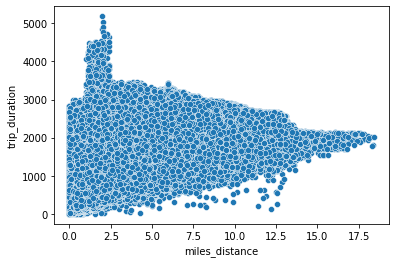

In [ ]:
# 分析距离特征，去除部分异常值
X_train['trip_duration'] = y

# 去除为0的duation特征
# X_train['trip_duration'],_ = boxcox(X_train['trip_duration'])
# X_train = X_train[X_train['trip_duration'] !=0].reset_index(drop=True)

# 去除 duration与 distance 比例不符合逻辑的数值
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state = 42, contamination = 0.01)
X_train['Anomaly'] = clf.fit_predict(X_train[['miles_distance', 'trip_duration']])
X_train = X_train.loc[X_train['Anomaly'] == 1].copy()
y = X_train.trip_duration

sns.scatterplot(data=X_train, x="miles_distance", y="trip_duration")

In [ ]:
# 删除不需要的特征数据

# print(X_train.columns)
# print(X_train.columns)

# X_train = X_train.drop(['Anomaly', 'trip_duration'],axis=1)
# X_train = X_train.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
# X_test = X_test.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429647 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1429647 non-null  int64  
 1   distance            1429647 non-null  float64
 2   manhattan_distance  1429647 non-null  float64
 3   haversine_distance  1429647 non-null  float64
 4   miles_distance      1429647 non-null  float64
 5   bearing             1429647 non-null  float64
 6   month               1429647 non-null  object 
 7   day                 1429647 non-null  object 
 8   weekday             1429647 non-null  int64  
 9   pickup_time         1429647 non-null  float64
 10  pickup_pca0         1429647 non-null  float64
 11  pickup_pca1         1429647 non-null  float64
 12  dropoff_pca0        1429647 non-null  float64
 13  dropoff_pca1        1429647 non-null  float64
 14  pickup_borough      1429647 non-null  int64  
 15  dropoff_borough

In [ ]:
# 备份
train_backup = X_train.copy()
duation_backup = y.copy()
test_backup = X_test.copy()

# 在谷歌网盘上保存数据
X_train.to_csv('train_data.csv',index=False)
y.to_csv('train_duation_data.csv',index=False)
X_test.to_csv('test_data.csv',index=False)

# # 下载数据
# from google.colab import files
# files.download('train_data.csv')
# files.download('train_duation_data.csv')
# files.download('test_data.csv')

In [ ]:
X_train = train_backup
y = duation_backup
X_test = test_backup

In [ ]:
# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 线性归一化
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler() 
X_train_scaled_linear = min_max_scaler.fit_transform(X_train)  
X_test_scaled_linear = min_max_scaler.fit_transform(X_test)

In [ ]:
'''
y 是训练集的 trip_duration
X_train 是没有标准化的训练集
X_test 是没有标准化的测试集

X_train_scaled 是标准化之后的训练集
X_test_scaled 是标准化之后的测试集

X_train_scaled_linear 是线性归一化后的训练集
X_test_scaled_linear 是线性归一化后的测试集

目前有特征：
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1444061 non-null  int64     乘客数量  
 1   distance            1444061 non-null  float64   欧式距离
 2   manhattan_distance  1444061 non-null  float64   曼哈顿距离
 3   haversine_distance  1444061 non-null  float64   Haversine距离
 4   miles_distance      1444061 non-null  float64   考虑球面弧度后的距离
 5   bearing             1444061 non-null  float64   航向角
 6   month               1444061 non-null  object    月份
 7   day                 1444061 non-null  object    日期 
 8   weekday             1444061 non-null  int64     星期（星期一=0  ...  星期日=6 )  
 9   pickup_time         1444061 non-null  float64   上车时间
 10  pickup_pca0         1444061 non-null  float64   经过PCA 2D-2D之后的上车纬度
 11  pickup_pca1         1444061 non-null  float64   经过PCA 2D-2D之后的上车经度
 12  dropoff_pca0        1444061 non-null  float64   经过PCA 2D-2D之后的下车纬度
 13  dropoff_pca1        1444061 non-null  float64   经过PCA 2D-2D之后的下车经度
 14  pickup_borough      1444061 non-null  int64     上车区域  
 15  dropoff_borough     1444061 non-null  int64     下车区域  
 16  borough_speed       1444061 non-null  float64   区域速度
dtypes: float64(11), int64(4), object(2)


 如果觉得特征数据不够，可以说选择加入log等函数，生成新的数据？
 或者是根据passenger_count的数值，分类0人/1人/2人/2人以上，生成布尔特征
 也可以将日期分类成工作日和休息日，或者进一步细化出节假日等布尔

'''

'\ny 是训练集的 trip_duration\nX_train 是没有标准化的训练集\nX_test 是没有标准化的测试集\n\nX_train_scaled 是标准化之后的训练集\nX_test_scaled 是标准化之后的测试集\n\nX_train_scaled_linear 是线性归一化后的训练集\nX_test_scaled_linear 是线性归一化后的测试集\n\n目前有特征：\n #   Column              Non-Null Count    Dtype  \n---  ------              --------------    -----  \n 0   passenger_count     1444061 non-null  int64     乘客数量  \n 1   distance            1444061 non-null  float64   欧式距离\n 2   manhattan_distance  1444061 non-null  float64   曼哈顿距离\n 3   haversine_distance  1444061 non-null  float64   Haversine距离\n 4   miles_distance      1444061 non-null  float64   考虑球面弧度后的距离\n 5   bearing             1444061 non-null  float64   航向角\n 6   month               1444061 non-null  object    月份\n 7   day                 1444061 non-null  object    日期 \n 8   weekday             1444061 non-null  int64     星期（星期一=0  ...  星期日=6 )  \n 9   pickup_time         1444061 non-null  float64   上车时间\n 10  pickup_pca0         1444061 non-null  float64   经过PCA 2D-2D之后的上车纬度\n

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
linear_orig = X_train.copy()
print(linear_orig.cov())#计算协方差矩阵，观察多重共线性

linear_scaler = pd.DataFrame(X_train_scaled)
linear_scaler.columns = ['passenger_count','distance','manhattan_distance','haversine_distance','miles_distance','bearing','month','day','weekday','pickup_time','pickup_pca0','pickup_pca1','dropoff_pca0','dropoff_pca1','pickup_borough','dropoff_borough','borough_speed']


linear_MinMaxScaler = pd.DataFrame(X_train_scaled_linear)
linear_MinMaxScaler.columns = ['passenger_count','distance','manhattan_distance','haversine_distance','miles_distance','bearing','month','day','weekday','pickup_time','pickup_pca0','pickup_pca1','dropoff_pca0','dropoff_pca1','pickup_borough','dropoff_borough','borough_speed']
#linear_MinMaxScaler['duration'] = y

#将所有训练集划分
from sklearn.model_selection import train_test_split
from sklearn import model_selection
X_train_orig,X_test_orig,Y_train_orig,Y_test_orig = model_selection.train_test_split(linear_orig,y,test_size=0.35,random_state=1)
X_train_scaler,X_test_scaler,Y_train_scaler,Y_test_scaler = model_selection.train_test_split(linear_scaler,y,test_size=0.35,random_state=1)
X_train_MinMaxScaler,X_test_MinMaxScaler,Y_train_MinMaxScaler,Y_test_MinMaxScaler = model_selection.train_test_split(linear_MinMaxScaler,y,test_size=0.35,random_state=1)



                    passenger_count  ...  borough_speed
passenger_count            1.724525  ...       0.001970
distance                   0.370488  ...      31.598762
manhattan_distance         0.000470  ...       0.039669
haversine_distance         0.035010  ...       2.794176
miles_distance             0.021770  ...       1.739219
bearing                   -0.101108  ...      30.267210
weekday                    0.065354  ...       0.032155
pickup_time                0.077218  ...      -0.778604
pickup_pca0               -0.000023  ...      -0.012585
pickup_pca1               -0.000106  ...      -0.004450
dropoff_pca0               0.000093  ...      -0.040840
dropoff_pca1              -0.000053  ...      -0.006650
pickup_borough             0.000338  ...       0.144513
dropoff_borough           -0.000906  ...       0.393610
borough_speed              0.001970  ...       3.802364

[15 rows x 15 columns]


In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

Linreg = LinearRegression()
Linreg.fit(X_train_orig,Y_train_orig)
Y_pred_orig=Linreg.predict(X_test_orig)
MSE=mean_squared_error(Y_pred_orig,Y_test_orig)
predict_score=Linreg.score(X_test_orig,Y_test_orig)#模型解释度


In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

Linreg = LinearRegression()
Linreg.fit(X_train_scaler,Y_train_scaler)

# summary(Linreg)
# Linreg.summary
Y_pred_scaler=Linreg.predict(X_test_scaler)
MSE=mean_squared_error(Y_pred_scaler,Y_test_scaler)
predict_score=Linreg.score(X_test_scaler,Y_test_scaler)#模型解释度
#标准化后的系数绝对值大小，代表了这个变量的重要性

# print(Linreg.coef)
# print(Linreg.intercept_)

In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

Linreg = LinearRegression()
Linreg.fit(X_train_MinMaxScaler,Y_train_MinMaxScaler)
Y_pred_MinMaxScaler=Linreg.predict(X_test_MinMaxScaler)
MSE=mean_squared_error(Y_pred_MinMaxScaler,Y_test_MinMaxScaler)
predict_score=Linreg.score(X_test_MinMaxScaler,Y_test_MinMaxScaler)#模型解释度
#到此步为止，在17个指标的基础上建立线性回归
#接下来可以不断删去一些变量，来测试寻找较小的MSE，同时保持较高的解释度
#不过不论怎么调变量，测试集上的MSE都很大很大,模型解释度也很低
#不过通常，只采用一种距离，所以可以修改数据集，多次实验找出最合适的距离，还可以对比一下是否需要距离、时间变量

In [ ]:
MSE

138736.4951539506